## Filtering Arena

In [2]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])
os.environ['TOKENIZERS_PARALLELISM'] = "false"

cwd = os.getcwd()
print('Working directory:', cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)



Current conda environment: reinvent
Working directory: /home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [3]:
import numpy as np
import pandas as pd

from rdkit import Chem
import useful_rdkit_utils as uru

import pickle

import seaborn as sns

In [4]:
#Seaborn settings for visualizations

rc = {
    "axes.facecolor": "#f7f9fc",
    "figure.facecolor": "#f7f9fc",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

default_palette = 'tab10'

sns.set(rc=rc)
pd.set_option('display.max_columns', 35)
pd.options.display.float_format = '{:,.2f}'.format

## Generating Data

In [5]:
fragments = []

f = open("data/fragments.smi", "r")

for i in range(1, 51):
    mol = f.readline()
    fragments.append(mol[:-1])

### Generate a distribution from each fragment for each model

In [6]:
models = ['reinvent', 'crem', 'coati', 'safe']

#### Warning: The following 3 cells are dangerous:

In [7]:
# %%capture

# for fragment in fragments:
#     for model in models:

#         DF_FILEPATH = f'data/{model}_dataframe.csv'

#         arg1 = '--model'
#         arg2 = '--input_frag'
#         arg3 = '--sample'

#         args = ['python3', 'generate_analogs.py',
#                 arg1, model,
#                 arg2, fragment,
#                 arg3, '200']

#         # Change directory to generate analogs with python script
#         %cd ..

#         subprocess.run(args,
#                     stdout=subprocess.DEVNULL,
#                     stderr=subprocess.STDOUT)
                
#         # Change directory back to that of the current notebook
#         %cd experiments

#         df = pd.read_csv(DF_FILEPATH, index_col=0)

#         df['Model'] = model

#         if model == 'reinvent':
#             reinvent_distributions.append(df)
#         elif model == 'crem':
#             crem_distributions.append(df)
#         elif model == 'coati':
#             coati_distributions.append(df)
#         elif model == 'safe':
#             safe_distributions.append(df)

In [8]:
# data = {'reinvent' : reinvent_distributions,
#         'crem' : crem_distributions,
#         'coati' : coati_distributions,
#         'safe' : safe_distributions}

In [9]:
# with open('lists.pkl', 'wb') as file:
#     pickle.dump(data, file)

In [10]:
with open('lists.pkl', 'rb') as file:
    data = pickle.load(file)

### Concatenate data for each model

In [11]:
model_dfs = []

for model in models:

    distributions = data[model]
    model_df = pd.DataFrame()

    for df in distributions:

        model_df = pd.concat((model_df, df))

    model_dfs.append(model_df)

### Filtering invalid molecules

In [12]:
for i, df in enumerate(model_dfs):

    smiles_list = df['SMILES'].to_list()

    valid_smiles = []
    invalid_smiles = []

    for smiles in smiles_list:
        
        try:
            molecule = Chem.MolFromSmiles(smiles, sanitize=True)
            if molecule is not None:
                valid_smiles.append(True)
            else:
                valid_smiles.append(False)
        except Exception as e:
            invalid_smiles.append(smiles)
        
    model_dfs[i] = df[valid_smiles]

[20:48:42] WARNING: not removing hydrogen atom without neighbors
[20:48:42] WARNING: not removing hydrogen atom without neighbors
[20:48:42] WARNING: not removing hydrogen atom without neighbors
[20:48:42] WARNING: not removing hydrogen atom without neighbors
[20:48:42] WARNING: not removing hydrogen atom without neighbors
[20:48:42] WARNING: not removing hydrogen atom without neighbors
[20:48:42] WARNING: not removing hydrogen atom without neighbors
[20:48:42] WARNING: not removing hydrogen atom without neighbors
[20:48:42] WARNING: not removing hydrogen atom without neighbors
[20:48:42] WARNING: not removing hydrogen atom without neighbors
[20:48:42] WARNING: not removing hydrogen atom without neighbors
[20:48:42] WARNING: not removing hydrogen atom without neighbors
[20:48:42] WARNING: not removing hydrogen atom without neighbors
[20:48:42] WARNING: not removing hydrogen atom without neighbors
[20:48:42] WARNING: not removing hydrogen atom without neighbors
[20:48:42] WARNING: not r

In [13]:
len(model_dfs[3])

9999

## Filtering

In [14]:
d = {'reinvent' : np.zeros(9),
     'crem' : np.zeros(9),
     'coati' : np.zeros(9),
     'safe' : np.zeros(9)}

scores = pd.DataFrame(data = d, index = ['valid', 'duplicates', 'good rings', 'chemical stability', 'scaffold novelty', 'skeleton novelty', "Lilly_chem", "filters_NIBR", "rule_of_five"])

### Filter #1: Invalid SMILES strings

In [15]:
def num_valid(df):

    size = len(df)
    count = 0

    for smi in df.SMILES:

        mol = Chem.MolFromSmiles(smi)

        if mol is not None:
            count += 1

    return count / size

In [16]:
for model, df in zip(models, model_dfs):

    scores[model]['valid'] = num_valid(df)

[20:48:46] WARNING: not removing hydrogen atom without neighbors
[20:48:46] WARNING: not removing hydrogen atom without neighbors
[20:48:46] WARNING: not removing hydrogen atom without neighbors
[20:48:46] WARNING: not removing hydrogen atom without neighbors
[20:48:46] WARNING: not removing hydrogen atom without neighbors
[20:48:46] WARNING: not removing hydrogen atom without neighbors
[20:48:46] WARNING: not removing hydrogen atom without neighbors
[20:48:46] WARNING: not removing hydrogen atom without neighbors
[20:48:46] WARNING: not removing hydrogen atom without neighbors
[20:48:46] WARNING: not removing hydrogen atom without neighbors
[20:48:46] WARNING: not removing hydrogen atom without neighbors
[20:48:46] WARNING: not removing hydrogen atom without neighbors
[20:48:46] WARNING: not removing hydrogen atom without neighbors
[20:48:46] WARNING: not removing hydrogen atom without neighbors
[20:48:46] WARNING: not removing hydrogen atom without neighbors
[20:48:46] WARNING: not r

In [17]:
scores

,reinvent,crem,coati,safe
valid,1.00,1.00,1.00,1.00
duplicates,0.00,0.00,0.00,0.00
good rings,0.00,0.00,0.00,0.00
chemical stability,0.00,0.00,0.00,0.00
scaffold novelty,0.00,0.00,0.00,0.00
skeleton novelty,0.00,0.00,0.00,0.00
Lilly_chem,0.00,0.00,0.00,0.00
filters_NIBR,0.00,0.00,0.00,0.00
rule_of_five,0.00,0.00,0.00,0.00


### Filter #2: Duplicates

In [18]:
safe_df = model_dfs[3]

In [19]:
safe_df

,SMILES,Model
361,c1nc(C2CCOCC2)nc2c1CCN2,safe
73,c1nc(N2CCC2)nc2c1CCN2,safe
374,c1nc(-c2nn[nH]n2)nc2c1CCN2,safe
155,c1nc(SCCN2CCOCC2)nc2c1CCN2,safe
104,c1nc(N2CCCSCC2)nc2c1CCN2,safe
...,...,...
83,CC(C)C(=O)NC(c1nc2ccccc2n1-c1ccccc1)N1CCOCC1,safe
425,CC(C)C(=O)NC(c1nc2ccccc2n1C1CC1)N1CN(CC(=O)O)c...,safe
165,CC(C)C(=O)NC(c1cc2ccccc2nn1)c1nc2ccccc2n1CCC(=O)O,safe
266,CC(C)C(=O)NC(Nc1ccccc1)c1nc2ccccc2n1C1OC(CO)C(...,safe


In [20]:
for i, (model, df) in enumerate(zip(models, model_dfs)):

    mols = [Chem.MolFromSmiles(smi) for smi in df.SMILES]

    df['ROMol'] = mols

    df['inchi'] = df.ROMol.apply(Chem.MolToInchiKey)

    duplicates = df.drop_duplicates(subset="inchi")

    scores[model]['duplicates'] = len(duplicates) / len(df)

    df.drop_duplicates(subset="inchi", inplace=True)
    
    model_dfs[i] = df 

[20:48:55] WARNING: not removing hydrogen atom without neighbors
[20:48:55] WARNING: not removing hydrogen atom without neighbors
[20:48:55] WARNING: not removing hydrogen atom without neighbors
[20:48:55] WARNING: not removing hydrogen atom without neighbors
[20:48:55] WARNING: not removing hydrogen atom without neighbors
[20:48:55] WARNING: not removing hydrogen atom without neighbors
[20:48:55] WARNING: not removing hydrogen atom without neighbors
[20:48:55] WARNING: not removing hydrogen atom without neighbors
[20:48:55] WARNING: not removing hydrogen atom without neighbors
[20:48:55] WARNING: not removing hydrogen atom without neighbors
[20:48:55] WARNING: not removing hydrogen atom without neighbors
[20:48:55] WARNING: not removing hydrogen atom without neighbors
[20:48:55] WARNING: not removing hydrogen atom without neighbors
[20:48:55] WARNING: not removing hydrogen atom without neighbors
[20:48:55] WARNING: not removing hydrogen atom without neighbors
[20:48:55] WARNING: not r

In [21]:
scores

,reinvent,crem,coati,safe
valid,1.00,1.00,1.00,1.00
duplicates,0.91,0.94,0.85,0.80
good rings,0.00,0.00,0.00,0.00
chemical stability,0.00,0.00,0.00,0.00
scaffold novelty,0.00,0.00,0.00,0.00
skeleton novelty,0.00,0.00,0.00,0.00
Lilly_chem,0.00,0.00,0.00,0.00
filters_NIBR,0.00,0.00,0.00,0.00
rule_of_five,0.00,0.00,0.00,0.00


### Filter #3: Odd ring systems

In [22]:
def number_odd_rings(df):

    ring_system_lookup = uru.RingSystemLookup.default()
    df['ring_systems'] = df.SMILES.apply(ring_system_lookup.process_smiles)
    df[['min_ring','min_freq']] = df.ring_systems.apply(uru.get_min_ring_frequency).to_list()
    good_rings = df.query('min_freq > 100').copy()

    return len(good_rings) / len(df)

In [23]:
for model, df in zip(models, model_dfs):

    scores[model]['good rings'] = number_odd_rings(df)

[20:49:22] WARNING: not removing hydrogen atom without neighbors
[20:49:22] WARNING: not removing hydrogen atom without neighbors
[20:49:22] WARNING: not removing hydrogen atom without neighbors
[20:49:22] WARNING: not removing hydrogen atom without neighbors
[20:49:22] WARNING: not removing hydrogen atom without neighbors
[20:49:22] WARNING: not removing hydrogen atom without neighbors
[20:49:22] WARNING: not removing hydrogen atom without neighbors
[20:49:22] WARNING: not removing hydrogen atom without neighbors
[20:49:22] WARNING: not removing hydrogen atom without neighbors
[20:49:22] WARNING: not removing hydrogen atom without neighbors
[20:49:22] WARNING: not removing hydrogen atom without neighbors
[20:49:22] WARNING: not removing hydrogen atom without neighbors
[20:49:22] WARNING: not removing hydrogen atom without neighbors
[20:49:22] WARNING: not removing hydrogen atom without neighbors
[20:49:22] WARNING: not removing hydrogen atom without neighbors
[20:49:22] WARNING: not r

0.892	0.575	0.692	0.983333

In [24]:
scores

,reinvent,crem,coati,safe
valid,1.00,1.00,1.00,1.00
duplicates,0.91,0.94,0.85,0.80
good rings,0.96,0.86,0.82,0.91
chemical stability,0.00,0.00,0.00,0.00
scaffold novelty,0.00,0.00,0.00,0.00
skeleton novelty,0.00,0.00,0.00,0.00
Lilly_chem,0.00,0.00,0.00,0.00
filters_NIBR,0.00,0.00,0.00,0.00
rule_of_five,0.00,0.00,0.00,0.00


### Filter #4: Chemical Stability

In [25]:
reos = uru.REOS()
reos.set_active_rule_sets(["Dundee"])

In [26]:
def num_stable(df):

    temp_df = pd.DataFrame()

    temp_df[['rule_set','reos']] = [list(reos.process_mol(x)) for x in df.ROMol]

    return uru.value_counts_df(temp_df, "reos")['count'].values[0] / len(df)

In [27]:
for model, df in zip(models, model_dfs):

    scores[model]['chemical stability'] = num_stable(df)

In [28]:
scores

,reinvent,crem,coati,safe
valid,1.00,1.00,1.00,1.00
duplicates,0.91,0.94,0.85,0.80
good rings,0.96,0.86,0.82,0.91
chemical stability,0.81,0.53,0.73,0.44
scaffold novelty,0.00,0.00,0.00,0.00
skeleton novelty,0.00,0.00,0.00,0.00
Lilly_chem,0.00,0.00,0.00,0.00
filters_NIBR,0.00,0.00,0.00,0.00
rule_of_five,0.00,0.00,0.00,0.00


In [29]:

from medchem.structural.lilly_demerits import LillyDemeritsFilters

In [30]:
#def process_filters(alert: str):
    #if not isinstance(alert, str):
        #return None
    #alerts = alert.split(",")
    #output = set()
    #for alert in alerts:
        #if ":" in alert:
            #alert, value = alert.split(":")
        #output.add(alert)
    #return list(output)

In [31]:
def process_structural_alerts(df: pd.DataFrame, smiles_column: str):
    dfilter = LillyDemeritsFilters()
    smiles = df[smiles_column].to_list()
    results = dfilter(mols=[Chem.MolFromSmiles(smi) for smi in smiles])
    df["pass_structure_filter"] = results["pass_filter"]
    df["structure_filter_alerts"] = results["reasons"]
    return df

In [32]:
#model_dfs = [process_structural_alerts(df, "SMILES") for df in model_dfs]

In [33]:
model_dfs[0] = process_structural_alerts(model_dfs[0], "SMILES")

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [34]:
true_rate = model_dfs[0].pass_structure_filter.sum() / len(model_dfs[0])

In [35]:
print(true_rate)

0.9592397275324105


In [36]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.DataStructs import BulkTanimotoSimilarity

In [37]:
def extract_scaffold(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaffold)


def extract_scaffold_skeleton(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    scaffold = MurckoScaffold.MakeScaffoldGeneric(MurckoScaffold.GetScaffoldForMol(mol))
    return Chem.MolToSmiles(scaffold)



In [38]:
def get_scaffold_novelty(df, initial_frags):
    intial_scaffold = set([extract_scaffold(frag) for frag in initial_frags])
    initial_skeleton = set([extract_scaffold_skeleton(frag) for frag in initial_frags])

    model_scaffolds = set(df.SMILES.apply(extract_scaffold))
    model_skeletons = set(df.SMILES.apply(extract_scaffold_skeleton))

    novel_scaffolds = model_scaffolds - intial_scaffold
    novel_skeletons = model_skeletons - initial_skeleton

    return len(novel_scaffolds) / len(model_scaffolds), len(novel_skeletons) / len(model_skeletons)


In [39]:
for model, df in zip(models, model_dfs):

    scaffold_novelty, skeleton_novelty = get_scaffold_novelty(df, fragments)

    scores[model]['scaffold novelty'] = scaffold_novelty
    scores[model]['skeleton novelty'] = skeleton_novelty

[20:50:29] WARNING: not removing hydrogen atom without neighbors
[20:50:29] WARNING: not removing hydrogen atom without neighbors
[20:50:29] WARNING: not removing hydrogen atom without neighbors
[20:50:29] WARNING: not removing hydrogen atom without neighbors
[20:50:29] WARNING: not removing hydrogen atom without neighbors
[20:50:29] WARNING: not removing hydrogen atom without neighbors
[20:50:29] WARNING: not removing hydrogen atom without neighbors
[20:50:29] WARNING: not removing hydrogen atom without neighbors
[20:50:29] WARNING: not removing hydrogen atom without neighbors
[20:50:29] WARNING: not removing hydrogen atom without neighbors
[20:50:29] WARNING: not removing hydrogen atom without neighbors
[20:50:29] WARNING: not removing hydrogen atom without neighbors
[20:50:29] WARNING: not removing hydrogen atom without neighbors
[20:50:29] WARNING: not removing hydrogen atom without neighbors
[20:50:29] WARNING: not removing hydrogen atom without neighbors
[20:50:29] WARNING: not r

In [40]:
print(scores)

                    reinvent  crem  coati  safe
valid                   1.00  1.00   1.00  1.00
duplicates              0.91  0.94   0.85  0.80
good rings              0.96  0.86   0.82  0.91
chemical stability      0.81  0.53   0.73  0.44
scaffold novelty        0.98  0.98   0.99  0.99
skeleton novelty        0.96  0.96   0.97  0.99
Lilly_chem              0.00  0.00   0.00  0.00
filters_NIBR            0.00  0.00   0.00  0.00
rule_of_five            0.00  0.00   0.00  0.00


In [41]:

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

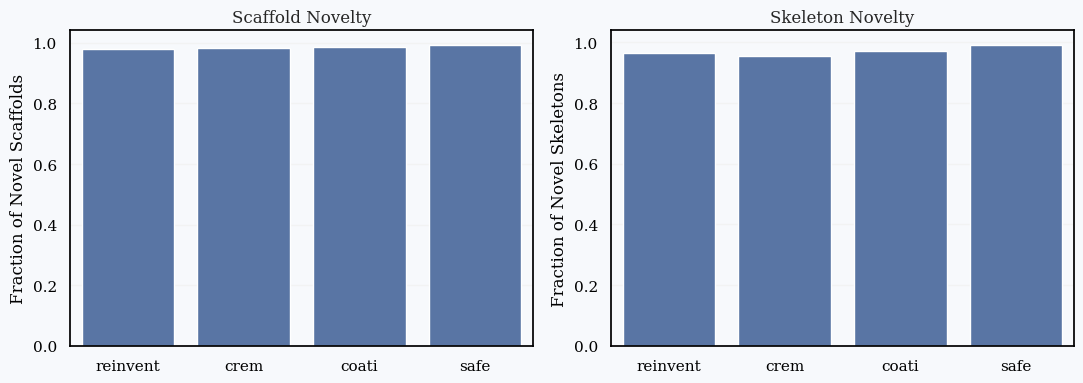

In [42]:
#make bar plot of scaffold novelty and skeleton novelty

fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax = ax.flatten()

scaffold_novelty = [scores[model]['scaffold novelty'] for model in models]
skeleton_novelty = [scores[model]['skeleton novelty'] for model in models]

sns.barplot(x=models, y=scaffold_novelty, ax=ax[0])
ax[0].set_title('Scaffold Novelty')
ax[0].set_ylabel('Fraction of Novel Scaffolds')

sns.barplot(x=models, y=skeleton_novelty, ax=ax[1])
ax[1].set_title('Skeleton Novelty')
ax[1].set_ylabel('Fraction of Novel Skeletons')

plt.tight_layout()
plt.show()

In [43]:
import medchem as mc

In [44]:
from rdkit.Chem import PandasTools
import datamol as dm

In [45]:
model_dfs[0]["mol"] = model_dfs[0]["SMILES"].apply(dm.to_mol)

In [46]:
def process_filters(data):

    data["rule_of_five"] = data["SMILES"].apply(mc.rules.basic_rules.rule_of_five)

    # Apply some default medchem filters
    data["alerts_Dundee"] = mc.functional.alert_filter(
        mols=data["mol"].tolist(),
        alerts=["Dundee"],
        n_jobs=-1,
        progress=True,
        return_idx=False,
    )

    data["alerts_SureChEMBL"] = mc.functional.alert_filter(
        mols=data["mol"].tolist(),
        alerts=["SureChEMBL"],
        n_jobs=-1,
        progress=True,
        return_idx=False,
    )

    data["filters_NIBR"] = mc.functional.nibr_filter(
        mols=data["mol"].tolist(),
        n_jobs=-1,
        progress=True,
        return_idx=False,
    )

    data["filter_molecular_graph"] = mc.functional.molecular_graph_filter(
        mols=data["mol"].tolist(),
        max_severity=5,
        n_jobs=-1,
        progress=True,
        return_idx=False,
    )

    data["filter_lilly_demerit"] = mc.functional.lilly_demerit_filter(
        mols=data["mol"].tolist(),
        n_jobs=-1,
        progress=True,
        return_idx=False,
    )

In [47]:

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

In [48]:
def plot_filters(data, model):
    filter_columns = [
        "rule_of_five",
        "alerts_Dundee",
        "alerts_SureChEMBL",
        "filters_NIBR",
        "filter_molecular_graph",
        "filter_lilly_demerit",
    ]

    # Some sorting for a nice plot
    data["n_filters_pass"] = data[filter_columns].sum(axis=1)
    data = data.sort_values("n_filters_pass", ascending=True)

    # Plot

    f, ax = plt.subplots(figsize=(14, 4), constrained_layout=True)

    cmap = matplotlib.colors.ListedColormap(["#EF6262", "#1D5B79"], None)

    a = sns.heatmap(
        data[filter_columns].T,
        annot=False,
        ax=ax,
        xticklabels=False,  # type: ignore
        yticklabels=True,  # type: ignore
        cbar=True,
        cmap=cmap,
    )

    ax.collections[0].colorbar.set_ticks([0.25, 0.75])
    ax.collections[0].colorbar.set_ticklabels(["Don't Pass", "Pass"], fontsize=14)

    ax.set_xlabel(f"Analogs from {model} sorted (n={len(data)})", fontsize=14)
    ax.set_ylabel("Medchem Filters", fontsize=18)

    # Add percentage of passing mols in the y labels
    new_ylabels = []
    for t in ax.yaxis.get_ticklabels():
        perc = data[t.get_text()].sum() / len(data) * 100
        new_ylabels.append(f"{t.get_text()} ({perc:.0f}%)")
    _ = ax.yaxis.set_ticklabels(new_ylabels, fontsize=12)


Common alerts filtering:   0%|          | 0/9102 [00:00<?, ?it/s]

Common alerts filtering:   0%|          | 0/9102 [00:00<?, ?it/s]

NIBR filtering:   0%|          | 0/9102 [00:00<?, ?it/s]

Match:   0%|          | 0/9102 [00:00<?, ?it/s]

Demerits filtering:   0%|          | 0/2 [00:00<?, ?it/s]

Common alerts filtering:   0%|          | 0/8674 [00:00<?, ?it/s]

Common alerts filtering:   0%|          | 0/8674 [00:00<?, ?it/s]

NIBR filtering:   0%|          | 0/8674 [00:00<?, ?it/s]

Match:   0%|          | 0/8674 [00:00<?, ?it/s]

Demerits filtering:   0%|          | 0/2 [00:00<?, ?it/s]

[20:54:01] WARNING: not removing hydrogen atom without neighbors
[20:54:01] WARNING: not removing hydrogen atom without neighbors
[20:54:01] WARNING: not removing hydrogen atom without neighbors
[20:54:01] WARNING: not removing hydrogen atom without neighbors
[20:54:01] WARNING: not removing hydrogen atom without neighbors
[20:54:01] WARNING: not removing hydrogen atom without neighbors
[20:54:01] WARNING: not removing hydrogen atom without neighbors
[20:54:01] WARNING: not removing hydrogen atom without neighbors
[20:54:01] WARNING: not removing hydrogen atom without neighbors
[20:54:01] WARNING: not removing hydrogen atom without neighbors
[20:54:01] WARNING: not removing hydrogen atom without neighbors
[20:54:01] WARNING: not removing hydrogen atom without neighbors
[20:54:01] WARNING: not removing hydrogen atom without neighbors
[20:54:01] WARNING: not removing hydrogen atom without neighbors
[20:54:01] WARNING: not removing hydrogen atom without neighbors
[20:54:01] WARNING: not r

Common alerts filtering:   0%|          | 0/5068 [00:00<?, ?it/s]

Common alerts filtering:   0%|          | 0/5068 [00:00<?, ?it/s]

NIBR filtering:   0%|          | 0/5068 [00:00<?, ?it/s]

Match:   0%|          | 0/5068 [00:00<?, ?it/s]

Demerits filtering:   0%|          | 0/2 [00:00<?, ?it/s]

[20:54:52] WARNING: not removing hydrogen atom without neighbors
[20:54:52] WARNING: not removing hydrogen atom without neighbors
[20:54:52] WARNING: not removing hydrogen atom without neighbors
[20:54:52] WARNING: not removing hydrogen atom without neighbors
[20:54:52] WARNING: not removing hydrogen atom without neighbors
[20:54:52] WARNING: not removing hydrogen atom without neighbors
[20:54:52] WARNING: not removing hydrogen atom without neighbors
[20:54:52] WARNING: not removing hydrogen atom without neighbors
[20:54:52] WARNING: not removing hydrogen atom without neighbors
[20:54:52] WARNING: not removing hydrogen atom without neighbors
[20:54:52] WARNING: not removing hydrogen atom without neighbors
[20:54:52] WARNING: not removing hydrogen atom without neighbors
[20:54:52] WARNING: not removing hydrogen atom without neighbors
[20:54:52] WARNING: not removing hydrogen atom without neighbors
[20:54:52] WARNING: not removing hydrogen atom without neighbors
[20:54:52] WARNING: not r

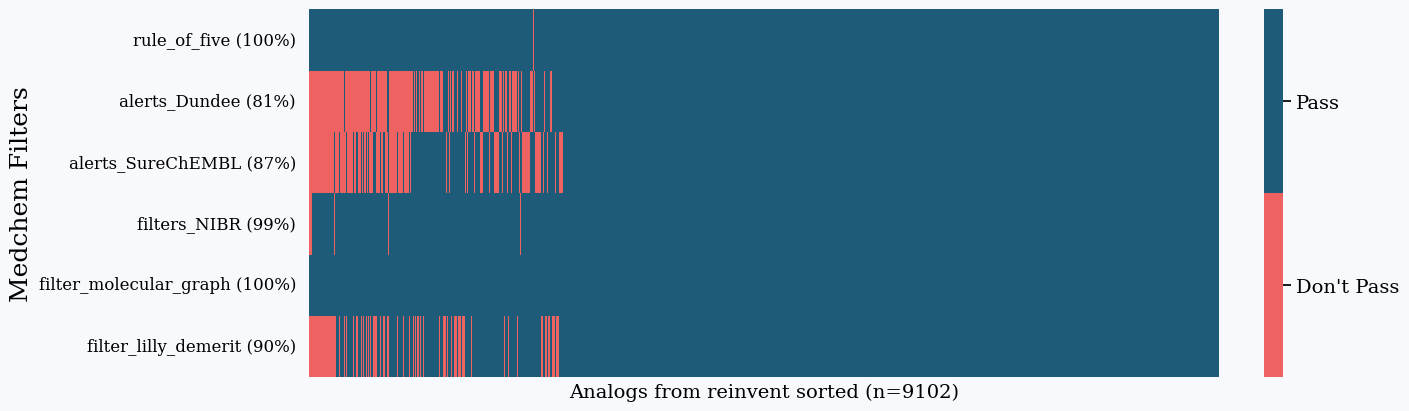

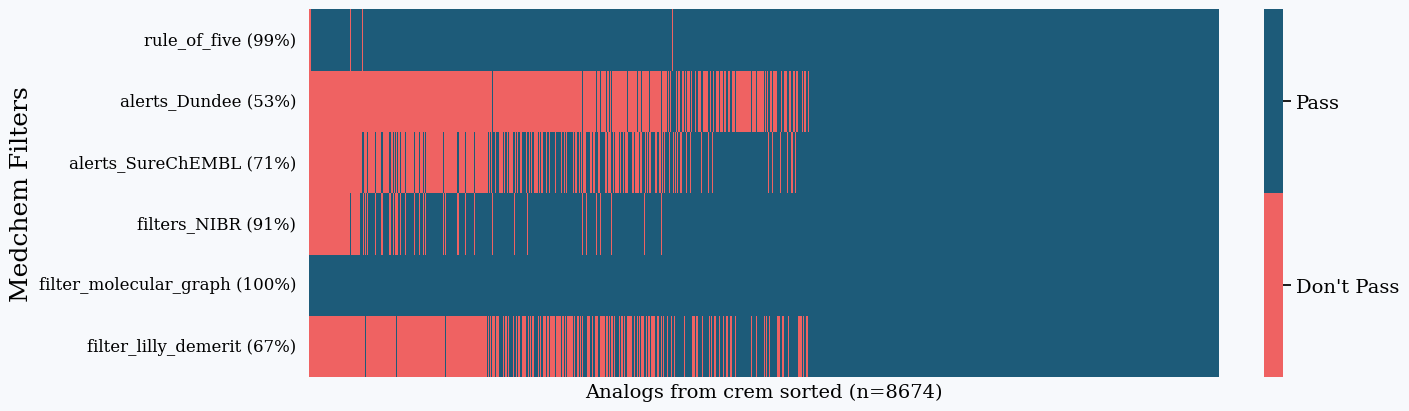

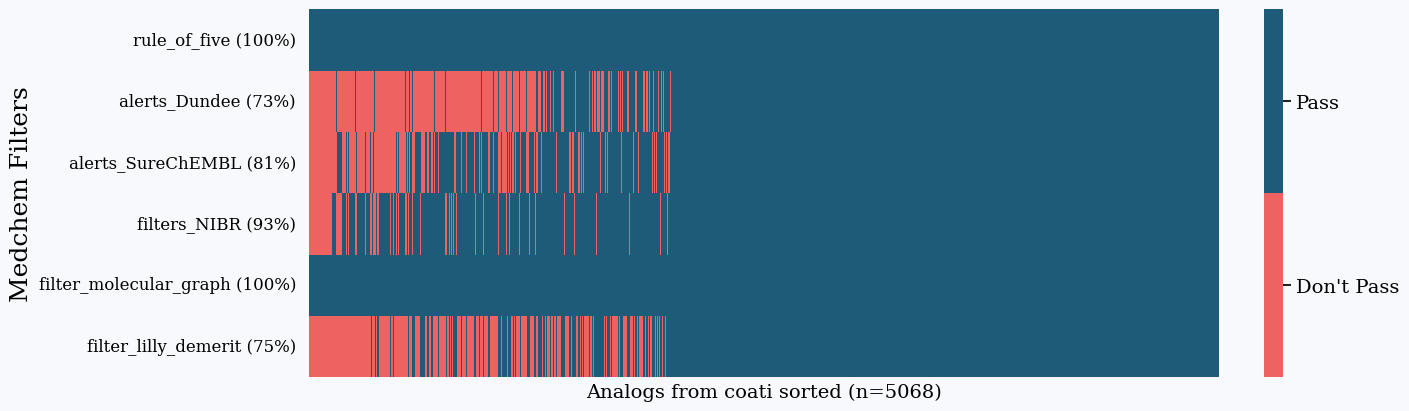

In [49]:
for model, df in zip(models[:3], model_dfs[:3]):

        df["mol"] = df["SMILES"].apply(dm.to_mol)
    
        process_filters(df)
    
        plot_filters(df, model)

In [50]:
model_dfs[3]["mol"] = model_dfs[3]["SMILES"].apply(dm.to_mol)
    

[20:54:56] WARNING: not removing hydrogen atom without neighbors
[20:54:56] WARNING: not removing hydrogen atom without neighbors
[20:54:56] WARNING: not removing hydrogen atom without neighbors
[20:54:56] WARNING: not removing hydrogen atom without neighbors


In [51]:
safe_1000 = model_dfs[3].sample(1900, random_state=42)

In [52]:
len(safe_1000)

1900

In [53]:
process_filters(safe_1000)

Common alerts filtering:   0%|          | 0/1900 [00:00<?, ?it/s]

Common alerts filtering:   0%|          | 0/1900 [00:00<?, ?it/s]

NIBR filtering:   0%|          | 0/1900 [00:00<?, ?it/s]

Match:   0%|          | 0/1900 [00:00<?, ?it/s]

In [54]:
safe_1000.head()

,SMILES,Model,ROMol,inchi,ring_systems,min_ring,min_freq,mol,rule_of_five,alerts_Dundee,alerts_SureChEMBL,filters_NIBR,filter_molecular_graph,filter_lilly_demerit
26,CC(C)C(=O)NC(c1nc2ccccc2n1-c1ccc(Cl)cc1)C1(F)CC1,safe,<rdkit.Chem.rdchem.Mol object at 0x705200a4dd20>,JHRQTYXVRNTCIM-UHFFFAOYSA-N,"[(c1ccc2[nH]cnc2c1, 43841), (C1CC1, 70914), (c...",c1ccc2[nH]cnc2c1,43841,<rdkit.Chem.rdchem.Mol object at 0x7052af952960>,True,True,True,True,True,True
371,Cc1c(OCc2ccccc2)c(C(F)(F)F)nc(C(F)(F)F)c1C(OCc...,safe,<rdkit.Chem.rdchem.Mol object at 0x705200b5be60>,UMMXMUMQRDBFMH-AJZOCDQUSA-N,"[(C1=CNCC1, 90), (c1ccncc1, 231698), (c1ccccc1...",C1=CNCC1,90,<rdkit.Chem.rdchem.Mol object at 0x7052ac4e2110>,False,True,True,True,True,False
60,CC(=O)N(C(=O)Nc1ccc(C(O)=Nc2cc(Cl)cc(Cl)c2)c(F...,safe,<rdkit.Chem.rdchem.Mol object at 0x705200ba7f40>,PIPVUUVPRHYSGR-UHFFFAOYSA-N,"[(c1ccccc1, 2260082), (c1ccccc1, 2260082)]",c1ccccc1,2260082,<rdkit.Chem.rdchem.Mol object at 0x7052ac4f4e40>,False,False,True,True,True,False
155,O=C(O)C(CNCP)Oc1c(C(F)(F)F)ccc(C(F)(F)F)c1F,safe,<rdkit.Chem.rdchem.Mol object at 0x705200a3e810>,YFACRQNXAMOHJH-UHFFFAOYSA-N,"[(c1ccccc1, 2260082)]",c1ccccc1,2260082,<rdkit.Chem.rdchem.Mol object at 0x7052af979000>,True,False,True,True,True,False
11,C[Si](C)(C)CCN(CO)C(=O)c1c(Cc2ccnc(C#N)c2)nc2c...,safe,<rdkit.Chem.rdchem.Mol object at 0x705200baa8f0>,VENABEPUIBHDDW-UHFFFAOYSA-N,"[(c1ccc2ncccc2c1, 57286), (c1ccc2[nH]ccc2c1, 9...",c1ccc2ncccc2c1,57286,<rdkit.Chem.rdchem.Mol object at 0x7052ac4f7610>,False,False,True,False,True,False


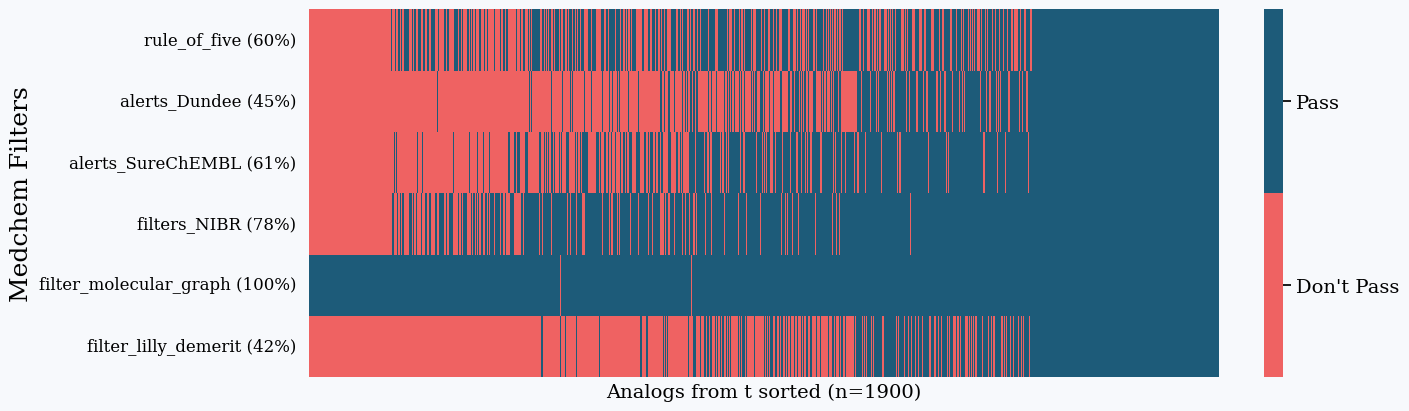

In [55]:
plot_filters(safe_1000, model[3])

In [56]:
model_dfs[2].head()

,SMILES,Model,ROMol,inchi,ring_systems,min_ring,min_freq,mol,rule_of_five,alerts_Dundee,alerts_SureChEMBL,filters_NIBR,filter_molecular_graph,filter_lilly_demerit,n_filters_pass
9,c1ncc2c(n1)NCCN2,coati,<rdkit.Chem.rdchem.Mol object at 0x7052010dcf20>,IDAICLIJTRXNER-UHFFFAOYSA-N,"[(c1ncc2c(n1)NCCN2, 114)]",c1ncc2c(n1)NCCN2,114,<rdkit.Chem.rdchem.Mol object at 0x7052af57b8b0>,True,True,True,True,True,True,6
253,c1cc2c(c(-c3cnc[nH]3)c1)OCC2,coati,<rdkit.Chem.rdchem.Mol object at 0x7052010ddc40>,WBNQVKNPPZKPOG-UHFFFAOYSA-N,"[(c1ccc2c(c1)CCO2, 3858), (c1c[nH]cn1, 66991)]",c1ccc2c(c1)CCO2,3858,<rdkit.Chem.rdchem.Mol object at 0x7052af57b530>,True,True,True,True,True,True,6
157,CNS(=O)(=O)c1ccc(-c2cncnc2)c2c1NCC2,coati,<rdkit.Chem.rdchem.Mol object at 0x7052010de180>,XCJBVZBIRPKCAN-UHFFFAOYSA-N,"[(c1ccc2c(c1)CCN2, 7904), (c1cncnc1, 81465)]",c1ccc2c(c1)CCN2,7904,<rdkit.Chem.rdchem.Mol object at 0x7052af57ab20>,True,True,True,True,True,True,6
209,C#Cc1c[n-]c2c1CNCC2,coati,<rdkit.Chem.rdchem.Mol object at 0x7052010de7a0>,LSDCQZLNMRPLKL-UHFFFAOYSA-N,"[(c1cc2c([n-]1)CCNC2, 0)]",c1cc2c([n-]1)CCNC2,0,<rdkit.Chem.rdchem.Mol object at 0x7052af57af10>,True,False,False,True,True,True,4
75,CC1=NCc2cnccc2N1,coati,<rdkit.Chem.rdchem.Mol object at 0x7052010df140>,VSFSMFKHWKOSKN-UHFFFAOYSA-N,"[(C1=NCc2cnccc2N1, 0)]",C1=NCc2cnccc2N1,0,<rdkit.Chem.rdchem.Mol object at 0x7052af579cb0>,True,True,True,True,True,True,6


In [57]:
model_dfs[3].head()

,SMILES,Model,ROMol,inchi,ring_systems,min_ring,min_freq,mol
361,c1nc(C2CCOCC2)nc2c1CCN2,safe,<rdkit.Chem.rdchem.Mol object at 0x705200cc1f50>,ULDKZNDWVXGVGS-UHFFFAOYSA-N,"[(c1ncc2c(n1)NCC2, 814), (C1CCOCC1, 64272)]",c1ncc2c(n1)NCC2,814,<rdkit.Chem.rdchem.Mol object at 0x7052ac880580>
73,c1nc(N2CCC2)nc2c1CCN2,safe,<rdkit.Chem.rdchem.Mol object at 0x705200ebeb20>,DNYKSENQXKNWNF-UHFFFAOYSA-N,"[(c1ncc2c(n1)NCC2, 814), (C1CNC1, 13255)]",c1ncc2c(n1)NCC2,814,<rdkit.Chem.rdchem.Mol object at 0x7052ac880350>
374,c1nc(-c2nn[nH]n2)nc2c1CCN2,safe,<rdkit.Chem.rdchem.Mol object at 0x705200ebd230>,TVHCZSJCHMFCHD-UHFFFAOYSA-N,"[(c1ncc2c(n1)NCC2, 814), (c1nn[nH]n1, 20601)]",c1ncc2c(n1)NCC2,814,<rdkit.Chem.rdchem.Mol object at 0x7052ac880900>
155,c1nc(SCCN2CCOCC2)nc2c1CCN2,safe,<rdkit.Chem.rdchem.Mol object at 0x705200ec2c00>,PAACHEIVJIWASK-UHFFFAOYSA-N,"[(c1ncc2c(n1)NCC2, 814), (C1COCCN1, 70960)]",c1ncc2c(n1)NCC2,814,<rdkit.Chem.rdchem.Mol object at 0x7052ac880820>
104,c1nc(N2CCCSCC2)nc2c1CCN2,safe,<rdkit.Chem.rdchem.Mol object at 0x705200ec4350>,WSYVFHAIHQTORR-UHFFFAOYSA-N,"[(C1CNCCSC1, 89), (c1ncc2c(n1)NCC2, 814)]",C1CNCCSC1,89,<rdkit.Chem.rdchem.Mol object at 0x7052ac880970>


In [60]:
model_dfs[1]["filter_lilly_demerit"].sum()/len(model_dfs[1])

0.6722388747982476

In [65]:
for model, df in zip(models[:3], model_dfs[:3]):

    scores[model]["Lilly_chem"] = df["filter_lilly_demerit"].sum()/len(df)
    scores[model]["filters_NIBR"] = df["filters_NIBR"].sum()/len(df)
    scores[model]["rule_of_five"] = df["rule_of_five"].sum()/len(df)

In [66]:
scores['safe']["Lilly_chem"] = safe_1000["filter_lilly_demerit"].sum()/len(safe_1000)
scores['safe']["filters_NIBR"] = safe_1000["filters_NIBR"].sum()/len(safe_1000)
scores['safe']["rule_of_five"] = safe_1000["rule_of_five"].sum()/len(safe_1000)



Make them into boxplots

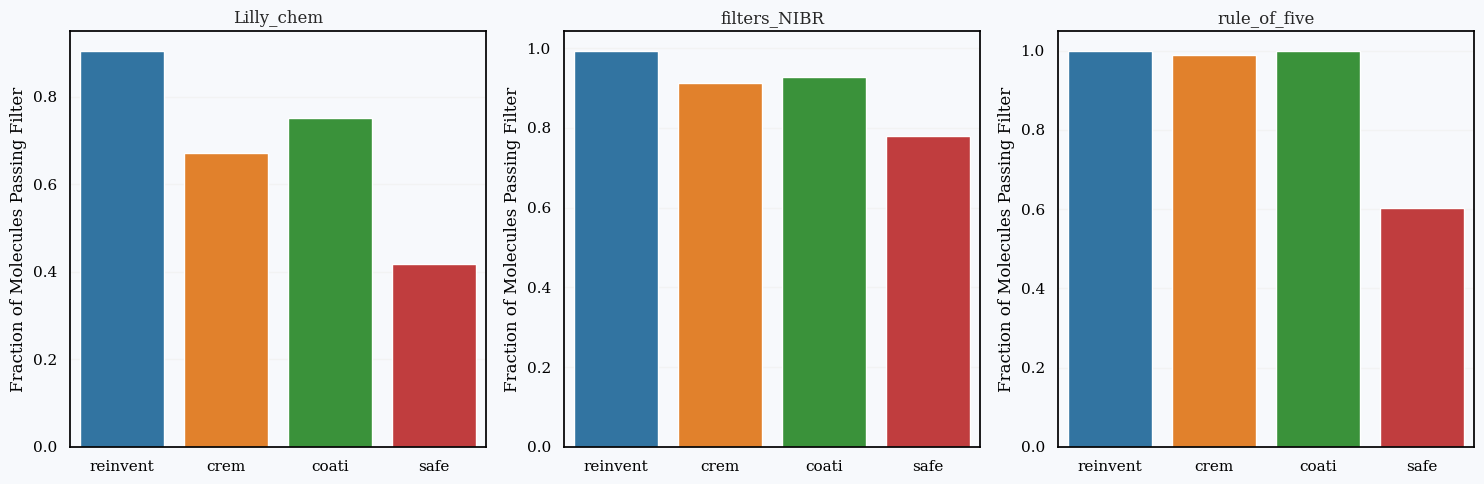

In [69]:
#make bar plots of the scores color coded by model for each filter

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, filter in enumerate(["Lilly_chem", "filters_NIBR", "rule_of_five"]):
        
            sns.barplot(x=models, y=[scores[model][filter] for model in models], ax=ax[i], palette=default_palette)
        
            ax[i].set_title(filter)
            ax[i].set_ylabel('Fraction of Molecules Passing Filter')

plt.tight_layout()
plt.show()

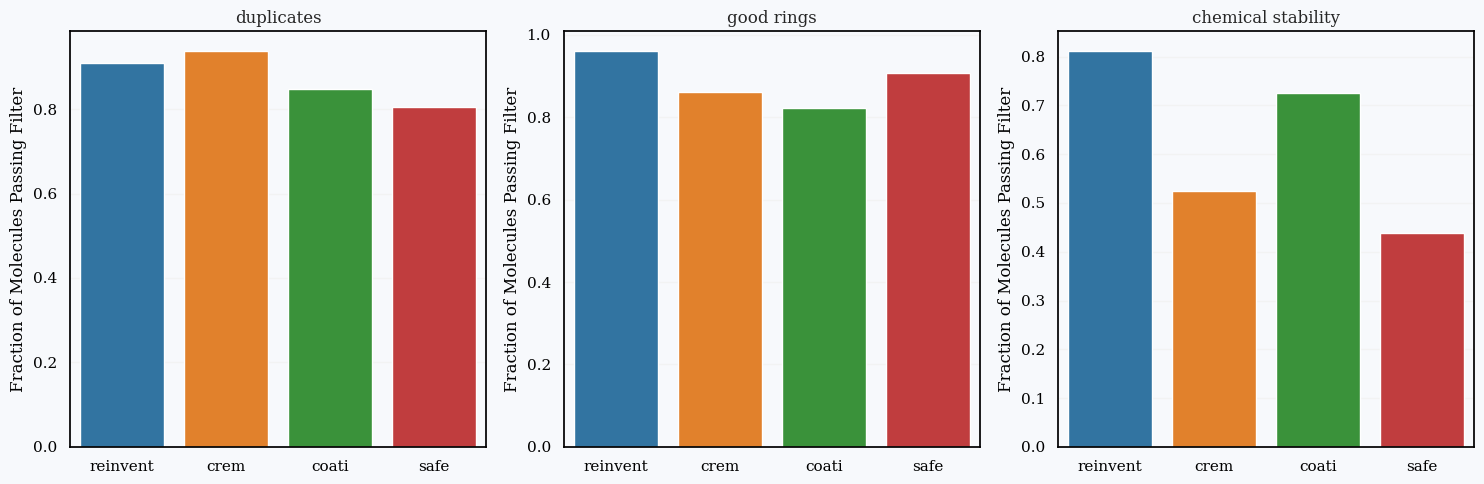

In [72]:
#Now we will do 'duplicates', 'good rings', 'chemical stability'

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, filter in enumerate(["duplicates", "good rings", "chemical stability"]):
            
                sns.barplot(x=models, y=[scores[model][filter] for model in models], ax=ax[i], palette=default_palette)
            
                ax[i].set_title(filter)
                ax[i].set_ylabel('Fraction of Molecules Passing Filter')

plt.tight_layout()

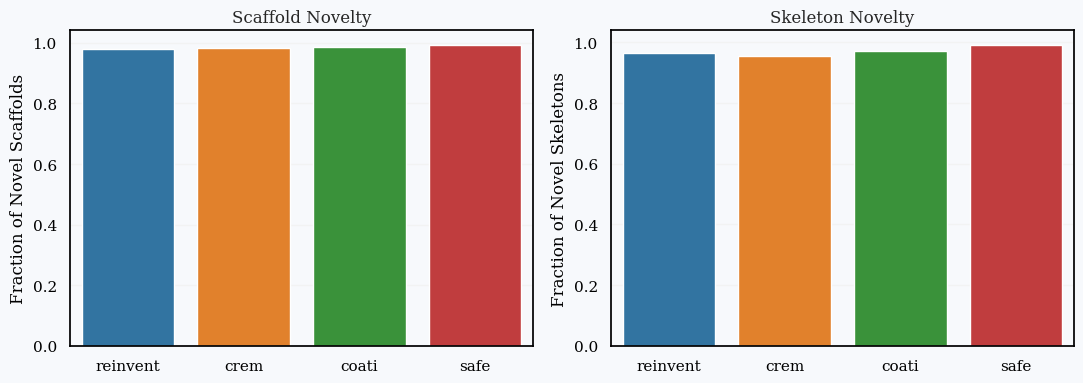

In [73]:
#Finally we will do 'scaffold novelty', 'skeleton novelty'

fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax = ax.flatten()

scaffold_novelty = [scores[model]['scaffold novelty'] for model in models]
skeleton_novelty = [scores[model]['skeleton novelty'] for model in models]

sns.barplot(x=models, y=scaffold_novelty, ax=ax[0], palette=default_palette)
ax[0].set_title('Scaffold Novelty')
ax[0].set_ylabel('Fraction of Novel Scaffolds')

sns.barplot(x=models, y=skeleton_novelty, ax=ax[1], palette=default_palette)
ax[1].set_title('Skeleton Novelty')
ax[1].set_ylabel('Fraction of Novel Skeletons')

plt.tight_layout()
plt.show()